This example is from [here](https://github.com/sharvaniyadav/Automated-Component-Detection-in-PCB-Manufacturing-YOLOv8/blob/main/kms.ipynb)

In [1]:
# Install Required Libraries
# !pip install ultralytics --quiet
# !pip install opencv-python-headless matplotlib Pillow --quiet

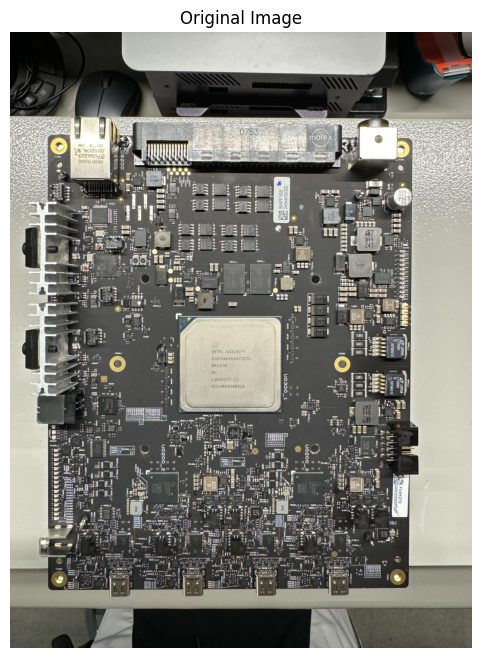

In [2]:
# Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

'''Step 1: Object Masking'''

# Step 1.2: Define the Path to Your Image and Load It
image_path = '/Users/alan/Desktop/MLCapstone/IMG_0015.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the file path.")

# Display the Original Image
plt.figure(figsize=(8, 8))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

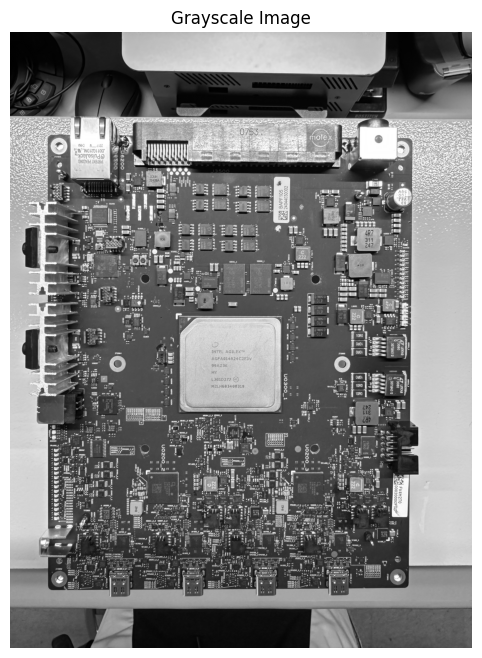

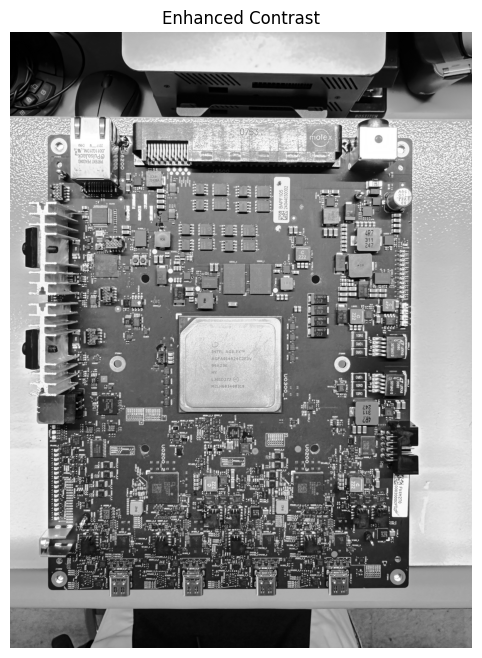

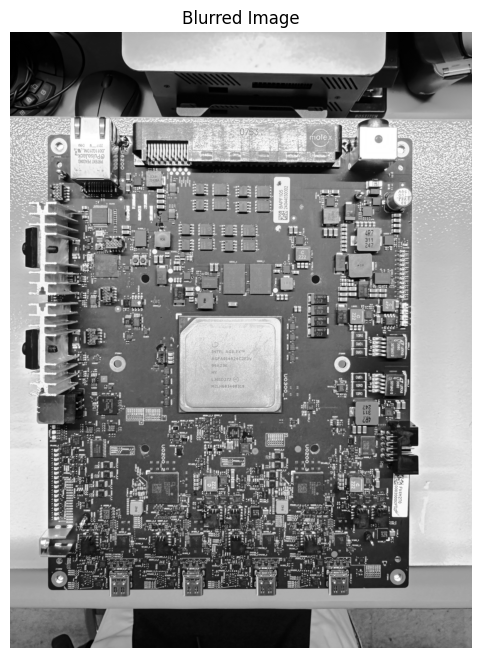

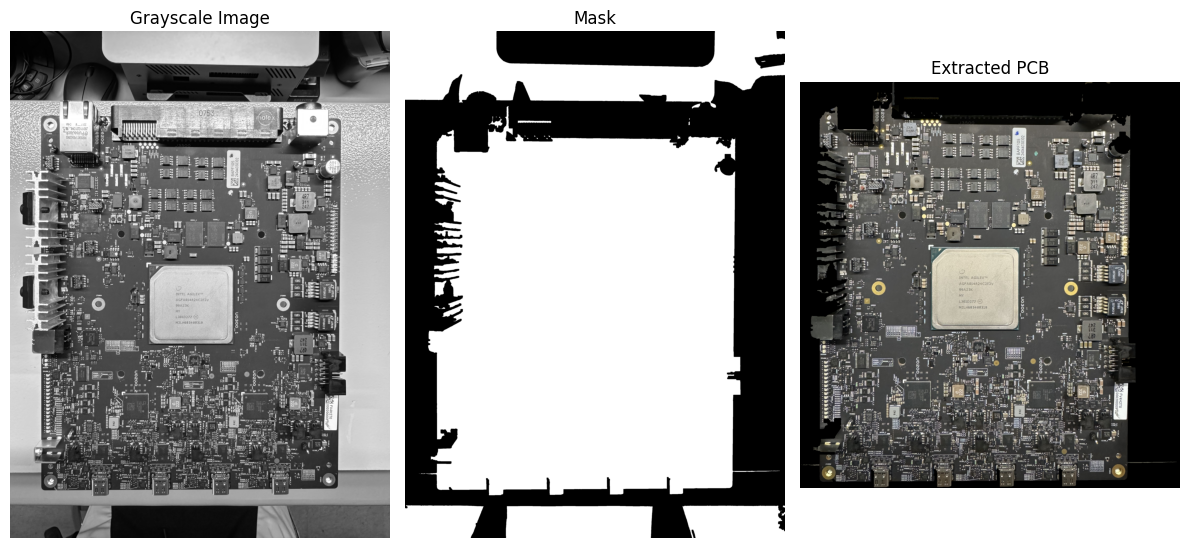

In [3]:

# Step 1.3: Convert to Grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display Grayscale Image
plt.figure(figsize=(8, 8))
plt.title("Grayscale Image")
plt.imshow(grayscale_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.4: Enhance Contrast
contrast_enhanced_image = cv2.equalizeHist(grayscale_image)

# Display Enhanced Contrast Image
plt.figure(figsize=(8, 8))
plt.title("Enhanced Contrast")
plt.imshow(contrast_enhanced_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.5: Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(contrast_enhanced_image, (5, 5), 0)

# Display Blurred Image
plt.figure(figsize=(8, 8))
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.6: Perform Thresholding
threshold_value = 130  # Try values like 80–130
_, binary_image = cv2.threshold(
    blurred_image, threshold_value, 255, cv2.THRESH_BINARY_INV
)


# Step 1.7: Morphological Cleaning
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Step 1.8: Detect and Filter Contours
contours, _ = cv2.findContours(
    cleaned_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
filtered_contours = [c for c in contours if cv2.contourArea(c) > 50000]

if not filtered_contours:
    raise ValueError("No significant contours found. Consider adjusting parameters.")

# Step 1.9: Create a Mask
pcb_mask = np.zeros_like(grayscale_image)
cv2.drawContours(pcb_mask, filtered_contours, -1, 255, cv2.FILLED)

# Step 1.10: Refine Mask Boundaries
refinement_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
refined_mask = cv2.erode(pcb_mask, refinement_kernel, iterations=1)

# Step 1.11: Extract the PCB
extracted_pcb = cv2.bitwise_and(image, image, mask=refined_mask)

# Step 1.12: Crop the PCB
x, y, w, h = cv2.boundingRect(max(filtered_contours, key=cv2.contourArea))
cropped_pcb = extracted_pcb[y:y+h, x:x+w]

# Step 1.13: Visualize Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Grayscale Image")
plt.imshow(cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(refined_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Extracted PCB")
plt.imshow(cv2.cvtColor(cropped_pcb, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
'''Step 2: YOLOv8 Training'''

# Step 2.1: Import Necessary Libraries
from ultralytics import YOLO
print("Libraries imported successfully.")

# Step 2.2: Load the YOLOv8 Nano Model
model = YOLO('yolov8n.pt')
print("YOLOv8 Nano model loaded with pretrained weights.")

# Step 2.3: Set Up Training Configuration
dataset_config_path = '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/pcb_wacv_2019/data.yaml'

# Validate dataset path
if not os.path.exists(dataset_config_path):
    raise FileNotFoundError(f"Dataset configuration file not found at: {dataset_config_path}")

Libraries imported successfully.
YOLOv8 Nano model loaded with pretrained weights.


In [ ]:

# Training parameters
total_epochs = 160
images_per_training_batch = 8
initial_learning_rate_value = 0.0004
type_of_optimizer_used = 'AdamW'
regularization_weight_value = 0.001

# Data-related parameters
resolution_of_input_images = 960
enable_data_augmentation_process = True
enable_mixed_precision_training_mode = True

# Step 2.4: Start Model Training
print("Initiating the training phase. Please allow some time for completion.")

result = model.train(
    name='pcb_model_training_process',   # Custom model name
    data=dataset_config_path,            # Dataset configuration file path
    imgsz=resolution_of_input_images,    # Input image resolution
    batch=images_per_training_batch,     # Batch size for training
    epochs=total_epochs,                 # Number of training epochs
    lr0=initial_learning_rate_value,     # Initial learning rate
    optimizer=type_of_optimizer_used,    # Optimizer type
    amp=enable_mixed_precision_training_mode,  # Enable mixed precision
    augment=enable_data_augmentation_process,  # Enable data augmentation
    weight_decay=regularization_weight_value,  # Regularization term
    device='cpu'                             # Use CPU for training
)

# Capture the output directory for trained weights
training_output_dir = result.save_dir
print(f"Training results saved in: {training_output_dir}")

# Step 2.5: Confirm Saved Results
if not os.path.exists(training_output_dir) or not os.listdir(training_output_dir):
    raise ValueError(f"No files were saved in the output directory: {training_output_dir}")

print("Model training has been successfully completed!")

Initiating the training phase. Please allow some time for completion.
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.70 🚀 Python-3.12.2 torch-2.6.0 CPU (Apple M4 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/pcb_wacv_2019/data.yaml, epochs=160, time=None, patience=100, batch=8, imgsz=960, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=pcb_model_training_process, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_d

train: Scanning /Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/pcb_wacv_2019/train/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]
val: Scanning /Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/pcb_wacv_2019/val/labels.cache... 46 images, 3 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]

Plotting labels to /Users/alan/Machine-Learning-and-AI-Bootcamp-projects/runs/detect/pcb_model_training_process/labels.jpg... 


optimizer: AdamW(lr=0.0004, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 0 dataloader workers
Logging results to /Users/alan/Machine-Learning-and-AI-Bootcamp-projects/runs/detect/pcb_model_training_process
Starting training for 160 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/160         0G      2.104      4.762      1.294       2876        960: 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.12s/it]

                   all         46      16159    0.00011    0.00258   7.88e-05   1.71e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/160         0G      2.149      4.255      1.179       3269        960: 100%|██████████| 6/6 [00:25<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.33s/it]

                   all         46      16159   6.67e-05    0.00156   3.53e-05   7.97e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/160         0G      2.144      3.954      1.154       4851        960: 100%|██████████| 6/6 [00:24<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.32s/it]

                   all         46      16159   6.67e-05    0.00156   3.53e-05   8.02e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/160         0G      2.186      3.705      1.142       6053        960: 100%|██████████| 6/6 [00:23<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.89s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.94s/it]

                   all         46      16159   0.000114    0.00163   6.14e-05    1.5e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/160         0G      2.098      3.524      1.137       4811        960: 100%|██████████| 6/6 [00:22<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.26s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.95s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.96s/it]

                   all         46      16159   0.000348    0.00496   0.000394   0.000143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/160         0G      2.142      3.351       1.14       3406        960: 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.10s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.79s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.77s/it]

                   all         46      16159   0.000487    0.00496   0.000802   0.000312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/160         0G      1.967      3.166      1.105       3817        960: 100%|██████████| 6/6 [00:25<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.15s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.95s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.91s/it]

                   all         46      16159     0.0206    0.00745     0.0116    0.00732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/160         0G      2.066      3.097      1.114       2646        960: 100%|██████████| 6/6 [00:24<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.88s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.84s/it]

                   all         46      16159     0.0588     0.0085     0.0105    0.00688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/160         0G      2.095      2.999      1.101       6011        960: 100%|██████████| 6/6 [00:25<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.90s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.84s/it]

                   all         46      16159     0.0603    0.00953     0.0116    0.00751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/160         0G      2.058      2.945      1.107       5884        960: 100%|██████████| 6/6 [00:23<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.25s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:08,  8.85s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.79s/it]

                   all         46      16159     0.0243     0.0101     0.0143    0.00873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/160         0G      2.008      2.914      1.093       2810        960: 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 1/3 [00:07<00:14,  7.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:17<00:09,  9.07s/it]

WARNING ⚠️ NMS time limit 2.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.99s/it]

                   all         46      16159     0.0195     0.0185     0.0155    0.00945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/160         0G      2.055      2.847      1.097       4387        960: 100%|██████████| 6/6 [00:24<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Check the type of the result object and inspect its attributes
print(type(result))
print(dir(result))

# Access the save_dir attribute or handle it dynamically
try:
    # Attempt to directly access save_dir as an attribute
    training_output_dir = result.save_dir
    print(f"Training results saved in: {training_output_dir}")
except AttributeError:
    # Handle the case where save_dir doesn't exist
    print("The 'save_dir' attribute is not directly accessible in 'result'.")

    # Inspect other attributes for clues
    print(f"Available attributes in 'result': {dir(result)}")

    # If no save_dir attribute exists, manually assign a directory
    training_output_dir = "/Users/alan/Desktop/MLCapstone"
    print(f"Manually assigned fallback directory: {training_output_dir}")

# Optional: Dynamically add the save_dir attribute back to the result object
result.save_dir = training_output_dir
print(f"'save_dir' attribute added to 'result': {result.save_dir}")


In [ ]:
''' STEP 3 '''

from ultralytics import YOLO
from IPython.display import Image, display
import os
import shutil

# Path to the trained model
trained_model_path = '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/runs/detect/pcb_model_training_process/weights/best.pt'

# Verify the trained model path
if not os.path.exists(trained_model_path):
    raise FileNotFoundError(f"Trained model not found at: {trained_model_path}. Ensure training completed successfully.")

print(f"Using trained model from: {trained_model_path}")

# Load the YOLO model
model = YOLO(trained_model_path)
print("Trained model loaded successfully.")

# Paths to evaluation images
evaluation_images = [
    '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/results/IMG_0015.jpg',
    "/Users/alan/Desktop/MLCapstone/pcb_wacv_2019/ACM-109_Bottom/ACM-109_Bottom.jpg"
]

# Google Drive directory to save results
google_drive_save_dir = '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/Capstone_Survey_Existing Research_and_Reproduce_Available_Solutions/Example Notebooks/results'
os.makedirs(google_drive_save_dir, exist_ok=True)

# Evaluate and save results
for image_path in evaluation_images:
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    print(f"Processing image: {image_path}")

    # Predict and save results to default directory
    results = model.predict(source=image_path, save=True, conf=0.5, imgsz=960)

    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        print("❌ No detections found at all.")
    else:
        print(f"✅ Detected {len(boxes)} objects.")
        print(boxes.cls)  # predicted class IDs
        print(boxes.conf)  # confidence scores
    # Locate the saved result from the default directory
    result_img_dir = '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/runs'
    detect_dir = '/Users/alan/Machine-Learning-and-AI-Bootcamp-projects/runs/detect'
    latest_result_dir = sorted(
        [os.path.join(detect_dir, d) for d in os.listdir(detect_dir) if os.path.isdir(os.path.join(detect_dir, d)) and d.startswith("predict")]
    )[-1]
    result_img_path = os.path.join(latest_result_dir, os.path.basename(image_path))
    print(f"result image path: {result_img_path}")

    # Verify result exists and copy to Google Drive
    if os.path.exists(result_img_path):
        destination_path = os.path.join(google_drive_save_dir, os.path.basename(image_path))
        shutil.copy(result_img_path, destination_path)
        print(f"Result saved to Google Drive: {destination_path}")
        display(Image(filename=destination_path))
    else:
        print(f"Result not found for image: {image_path}")

print("Evaluation complete.")
